In [4]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location

In [6]:
# !pip install cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

In [7]:
results_folder = 'cell2location/results/lymph_nodes_analysis/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [8]:
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

[03/08/25 12:01:26] WARNING  /var/folders/pg/0xvjlxmd65q8_d88281j4gs00000gp/T/ipykernel_21360/52005 ]8;id=892546;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=986957;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             3249.py:1: FutureWarning: Use `squidpy.datasets.visium` instead.                      
                               adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")                 
                                                                                                                   

  0%|          | 0.00/7.86M [00:00<?, ?B/s]

  0%|          | 0.00/29.3M [00:00<?, ?B/s]

[03/08/25 12:01:36] WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=589738;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=974036;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/scanpy/datasets/_dat                
                             asets.py:558: FutureWarning: Use `squidpy.read.visium` instead.                       
                               return read_visium(sample_dir, source_image_path=source_image_path)                 
                                                                                                                   

                    WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=356386;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=279492;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/anndata/_core/anndat                
                             a.py:1758: UserWarning: Variable names are not unique. To make them                   
                             unique, call `.var_names_make_unique`.                                                
                               utils.warn_names_duplicates("var")                                                  
                                                                                                                   

                    WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=717188;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=677060;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/anndata/_core/anndat                
                             a.py:1758: UserWarning: Variable names are not unique. To make them                   
                             unique, call `.var_names_make_unique`.                                                
                               utils.warn_names_duplicates("var")                                                  
                                                                                                                   

In [9]:
# Here we rename genes to ENSEMBL ID for correct matching between single cell and spatial data - so you can ignore the 
#scanpy suggestion to call .var_names_make_unique.
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

[03/08/25 12:02:56] WARNING  /var/folders/pg/0xvjlxmd65q8_d88281j4gs00000gp/T/ipykernel_21360/12206 ]8;id=224544;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=418382;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             94083.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.                  
                               sc.pl.spatial(adata_vis, color='PTPRC', gene_symbols='SYMBOL')                      
                                                                                                                   

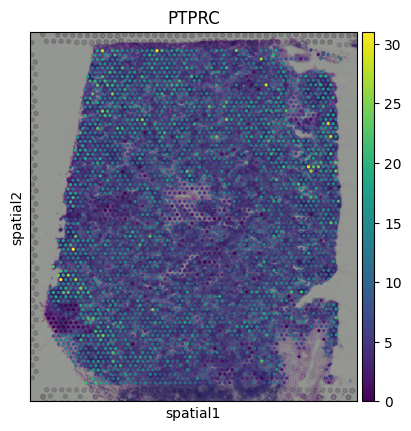

In [12]:
sc.pl.spatial(adata_vis, color='PTPRC', gene_symbols='SYMBOL')

Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.

In [13]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

Published scRNA-seq datasets of lymph nodes have typically lacked an adequate representation of germinal centre-associated immune cell populations due to age of patient donors. We, therefore, include scRNA-seq datasets spanning lymph nodes, spleen and tonsils in our single-cell reference to ensure that we captured the full diversity of immune cell states likely to exist in the spatial transcriptomic dataset.

Here we download this dataset, import into anndata and change variable names to ENSEMBL gene identifiers.

In [14]:
# Read data
adata_ref = sc.read(
    f'./data/sc.h5ad',
    backup_url='https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad'
)

  0%|          | 0.00/527M [00:00<?, ?B/s]

Note!

Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.

The default parameters cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12 are a good starting point, however, you can increase the cut-off to exclude more genes. To preserve marker genes of rare cell types we recommend low cell_count_cutoff=5, however, cell_percentage_cutoff2 and nonz_mean_cutoff can be increased to select between 8k-16k genes.

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

In this case, the downloaded dataset was already filtered using this method, hence no density under the orange rectangle (to be changed in the future version of the tutorial).

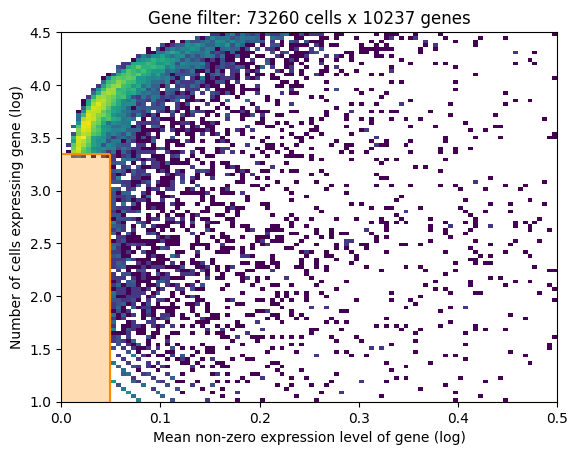

In [15]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

Estimation of reference cell type signatures (NB regression)
The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

Preparing anndata.

First, prepare anndata object for the regression model:

In [16]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
    # 10X reaction / sample / batch
    batch_key='Sample',
    # cell type, covariate used for constructing signatures
    labels_key='Subset',
    # multiplicative technical effects (platform, 3' vs 5', donor effect)
    categorical_covariate_keys=['Method']
   )

In [17]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.2.post2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': ['Method'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  23   │
│         n_cells          │ 73260 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  34   │
│          n_vars          │ 10237 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │    4861STDY7135913     │          0          │
│                     │    4861STDY7135914     │          1          │
│                     │    4861STDY7208412     │          2          │
│                     │    4861STDY7208413     │          3          │
│                     │    4861STDY7462253     │          4          │
│                     │    4861STDY7462254     │          5          │
│                     │    4861STDY7462255     │          6          │
│                     │    4861STDY7462256     │          7          │
│                     │    4861STDY7528597     │          8          │
│                     │    4861STDY7528598     │          9          │
│                     │    4861STDY7528599     │         10          │
│                     │    4861STDY7528600     │         11          │
│                     │      BCP002_Total      │         12          │
│                     │      BCP003_Total      │         13          │
│                     │      BCP004_Total      │         14          │
│                     │      BCP005_Total      │         15          │
│                     │      BCP006_Total      │         16          │
│                     │      BCP008_Total      │         17          │
│                     │      BCP009_Total      │         18          │
│                     │ Human_colon_16S7255677 │         19          │
│                     │ Human_colon_16S7255678 │         20          │
│                     │ Human_colon_16S8000484 │         21          │
│                     │      Pan_T7935494      │         22          │
└─────────────────────┴────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │    B_Cycling     │          0          │
│                     │     B_GC_DZ      │          1          │
│                     │     B_GC_LZ      │          2          │
│                     │    B_GC_prePB    │          3          │
│                     │      B_IFN       │          4          │
│                     │   B_activated    │          5          │
│                     │      B_mem       │          6          │
│                     │     B_naive      │          7          │
│                     │     B_plasma     │          8          │
│                     │     B_preGC      │          9          │
│                     │     DC_CCR7+     │         10          │
│                     │     DC_cDC1      │         11          │
│                     │     DC_cDC2      │         12          │
│                     │      DC_pDC      │         13          │
│                     │       Endo       │         14          │
│                     │       FDC        │         15          │
│                     │       ILC        │         16          │
│                     │  Macrophages_M1  │         17          │
│                     │  Macrophages_M2  │         18          │
│                     │       Mast       │         19          │
│                     │    Monocytes     │         20          │
│                     │        NK        │         21          │
│                     │       NKT        │         22          │
│                     │      T_CD4+      │         23          │
│                     │    T_CD4+_TfH    │         24          │
│                     │  T_CD4+_TfH_GC   │         25          │
│                     │   T_CD4+_naive   │         26          │
│                     │  T_CD8+_CD161+   │         27          │
│                     │ T_CD8+_cytotoxic │         28          │
│                     │   T_CD8+_naive   │         29          │
│                     │     T_TIM3+      │         30          │
│                     │      T_TfR       │         31          │
│                     │      T_Treg      │         32          │
│                     │       VSMC       │         33          │
└─────────────────────┴──────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │    3GEX    │          0          │
│                     │    5GEX    │          1          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

Training model.

Now we train the model to estimate the reference cell type signatures.

Note that to achieve convergence on your data (=to get stabilization of the loss) you may need to increase max_epochs=250 (See below).

Also note that here we are using batch_size=2500 which is much larger than scvi-tools default and perform training on all cells in the data (train_size=1) - both parameters are defaults.

In [ ]:
mod.train(max_epochs=100)

[03/08/25 12:15:52] WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=381689;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=204701;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/scvi/train/_trainrun                
                             ner.py:69: UserWarning: `accelerator` has been automatically set to                   
                             `cpu` although 'mps' exists. If you wish to run on mps backend, use                   
                             explicitly accelerator=='mps' in train function.In future releases it                 
                             will become default for mps supported machines.                                       
                               accelerator, lightning_devices, device = parse_device_args(                         
                                                                                                                   

INFO: GPU available: True (mps), used: False


                    INFO     GPU available: True (mps), used: False                                 ]8;id=674146;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=46132;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: TPU available: False, using: 0 TPU cores


                    INFO     TPU available: False, using: 0 TPU cores                               ]8;id=33504;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=963585;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: HPU available: False, using: 0 HPUs


                    INFO     HPU available: False, using: 0 HPUs                                    ]8;id=843042;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=16913;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

                    WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=142175;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=361938;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning/pytorch/tr                
                             ainer/setup.py:177: GPU available but not used. You can set it by                     
                             doing `Trainer(accelerator='gpu')`.                                                   
                                                                                                                   

                    WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=496526;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=897331;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning/pytorch/tr                
                             ainer/configuration_validator.py:68: You passed in a `val_dataloader`                 
                             but have no `validation_step`. Skipping val loop.                                     
                                                                                                                   

                    WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=616918;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=923978;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning/pytorch/tr                
                             ainer/connectors/data_connector.py:425: The 'train_dataloader' does                   
                             not have many workers which may be a bottleneck. Consider increasing                  
                             the value of the `num_workers` argument` to `num_workers=10` in the                   
                             `DataLoader` to improve performance.                                                  
                                                                                                                   

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Determine if the model needs more training.

Here, we plot ELBO loss history during training, removing first 20 epochs from the plot. This plot should have a decreasing trend and level off by the end of training. If it is still decreasing, increase max_epochs.

In [ ]:
mod.plot_history(20)

### Baixar os dados da Mariana, fazer o filtro

Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.

### Treinar o modelo com cell2celllocation